# OpenSCM

This notebook will provide a demo of OpenSCM. At the moment it just shows how to load the rcps, introducing the basic emissions scenario format.

In [1]:
# NBVAL_IGNORE_OUTPUT
from openscm.scenarios import rcps

<IPython.core.display.Javascript object>

In [2]:
import seaborn as sns
sns.set(style="darkgrid")

Emissions scenarios in OpenSCM should be provided as `ScmDataFrame`'s. These are wrappers around pyam's `IamDataFrame` which focus on simple climate model data whilst retaining all of the data analysis tools present in pyam.

In [3]:
type(rcps)

openscm.scmdataframebase.ScmDataFrameBase

In [4]:
# NBVAL_IGNORE_OUTPUT
rcps.head()

time                                                               1765-07-12 00:00:00  \
model scenario region variable        unit          climate_model                        
IMAGE RCP26    World  Emissions|BC    Mt BC / yr    unspecified               0.000000   
                      Emissions|C2F6  kt C2F6 / yr  unspecified               0.000000   
                      Emissions|C6F14 kt C6F14 / yr unspecified               0.000000   
                      Emissions|CCl4  kt CCl4 / yr  unspecified               0.000000   
                      Emissions|CF4   kt CF4 / yr   unspecified               0.010763   

time                                                               1766-07-12 00:00:00  \
model scenario region variable        unit          climate_model                        
IMAGE RCP26    World  Emissions|BC    Mt BC / yr    unspecified               0.106998   
                      Emissions|C2F6  kt C2F6 / yr  unspecified               0.000000   
                      Emissions|C6F14 kt C6F14 / yr unspecified               0.000000   
                      Emissions|CCl4  kt CCl4 / yr  unspecified               0.000000   
                      Emissions|CF4   kt CF4 / yr   unspecified               0.010752   

time                                                               1767-07-12 00:00:00  \
model scenario region variable        unit          climate_model                        
IMAGE RCP26    World  Emissions|BC    Mt BC / yr    unspecified               0.133383   
                      Emissions|C2F6  kt C2F6 / yr  unspecified               0.000000   
                      Emissions|C6F14 kt C6F14 / yr unspecified               0.000000   
                      Emissions|CCl4  kt CCl4 / yr  unspecified               0.000000   
                      Emissions|CF4   kt CF4 / yr   unspecified               0.010748   

time                                                               1768-07-12 00:00:00  \
model scenario region variable        unit          climate_model                        
IMAGE RCP26    World  Emissions|BC    Mt BC / yr    unspecified               0.159847   
                      Emissions|C2F6  kt C2F6 / yr  unspecified               0.000000   
                      Emissions|C6F14 kt C6F14 / yr unspecified               0.000000   
                      Emissions|CCl4  kt CCl4 / yr  unspecified               0.000000   
                      Emissions|CF4   kt CF4 / yr   unspecified               0.010744   

time                                                               1769-07-12 00:00:00  \
model scenario region variable        unit          climate_model                        
IMAGE RCP26    World  Emissions|BC    Mt BC / yr    unspecified               0.186393   
                      Emissions|C2F6  kt C2F6 / yr  unspecified               0.000000   
                      Emissions|C6F14 kt C6F14 / yr unspecified               0.000000   
                      Emissions|CCl4  kt CCl4 / yr  unspecified               0.000000   
                      Emissions|CF4   kt CF4 / yr   unspecified               0.010740   

time                                                               1770-07-12 00:00:00  \
model scenario region variable        unit          climate_model                        
IMAGE RCP26    World  Emissions|BC    Mt BC / yr    unspecified               0.213024   
                      Emissions|C2F6  kt C2F6 / yr  unspecified               0.000000   
                      Emissions|C6F14 kt C6F14 / yr unspecified               0.000000   
                      Emissions|CCl4  kt CCl4 / yr  unspecified               0.000000   
                      Emissions|CF4   kt CF4 / yr   unspecified               0.010736   

time                                                               1771-07-12 00:00:00  \
model scenario region variable        unit          climate_model                        
IMAGE RCP26    World  Emissions|BC

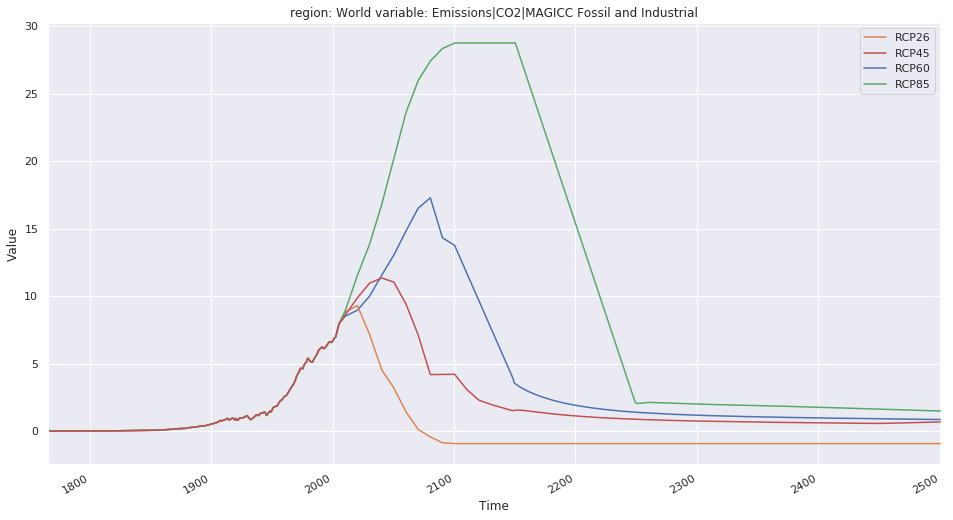

In [5]:
rcps.filter(
    variable="Emissions|CO2|*Fossil*"
).to_iamdataframe().line_plot(
    x="time", 
    figsize=(16, 9), 
    color="scenario"
);